<h1> ENSEMBLE METHODS : BAGGING AND BOOSTING DEMONSTRATION </h1>

<h2> A. CUSTOM IMPLEMENTATION OF RANDOM FOREST (BAGGING) FOR CLASSIFICATION </h2>

<h3> EXPLORATORY DATA ANALYSIS OF THE SYNTHETIC DATASET </h3>

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Feature_0   300 non-null    float64
 1   Feature_1   300 non-null    float64
 2   Feature_2   300 non-null    float64
 3   Feature_3   300 non-null    float64
 4   Feature_4   300 non-null    float64
 5   Feature_5   300 non-null    float64
 6   Feature_6   300 non-null    float64
 7   Feature_7   300 non-null    float64
 8   Feature_8   300 non-null    float64
 9   Feature_9   300 non-null    float64
 10  Feature_10  300 non-null    float64
 11  Feature_11  300 non-null    float64
 12  Feature_12  300 non-null    float64
 13  Feature_13  300 non-null    float64
 14  Feature_14  300 non-null    float64
 15  Feature_15  300 non-null    float64
 16  Feature_16  300 non-null    float64
 17  Feature_17  300 non-null    float64
 18  Feature_18  300 non-null    float64
 19  Feature_19 

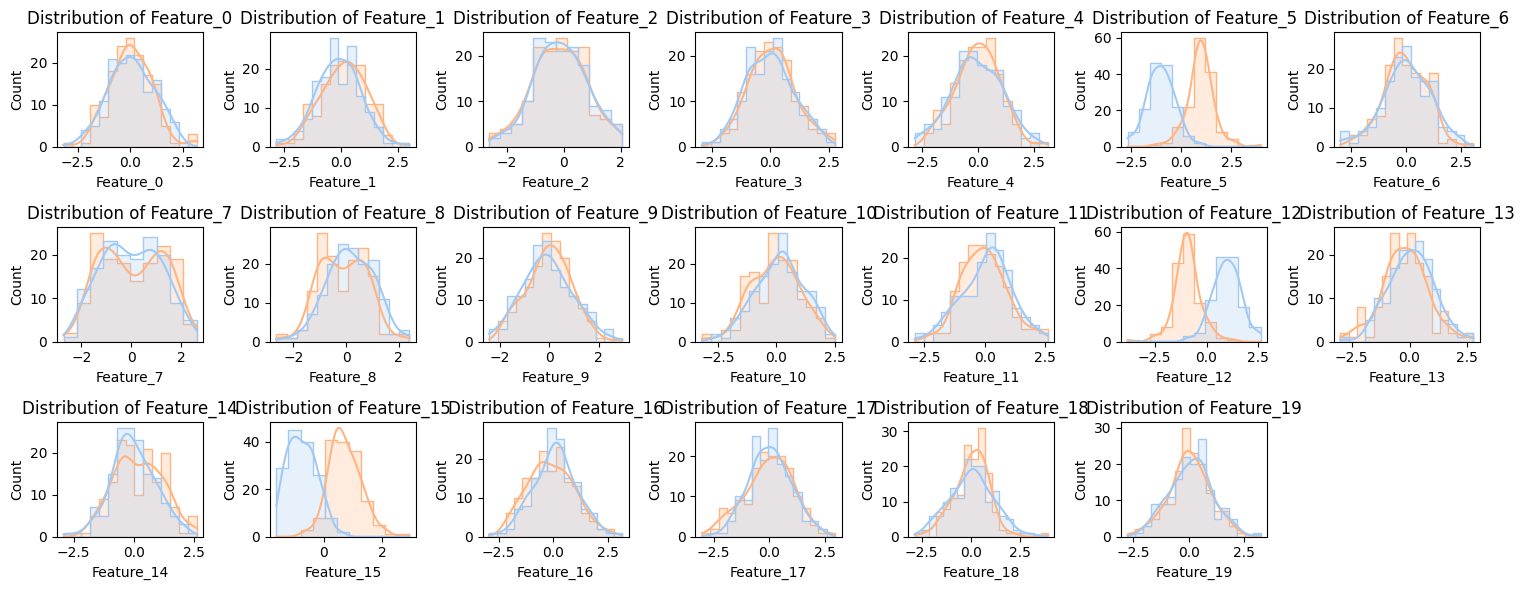

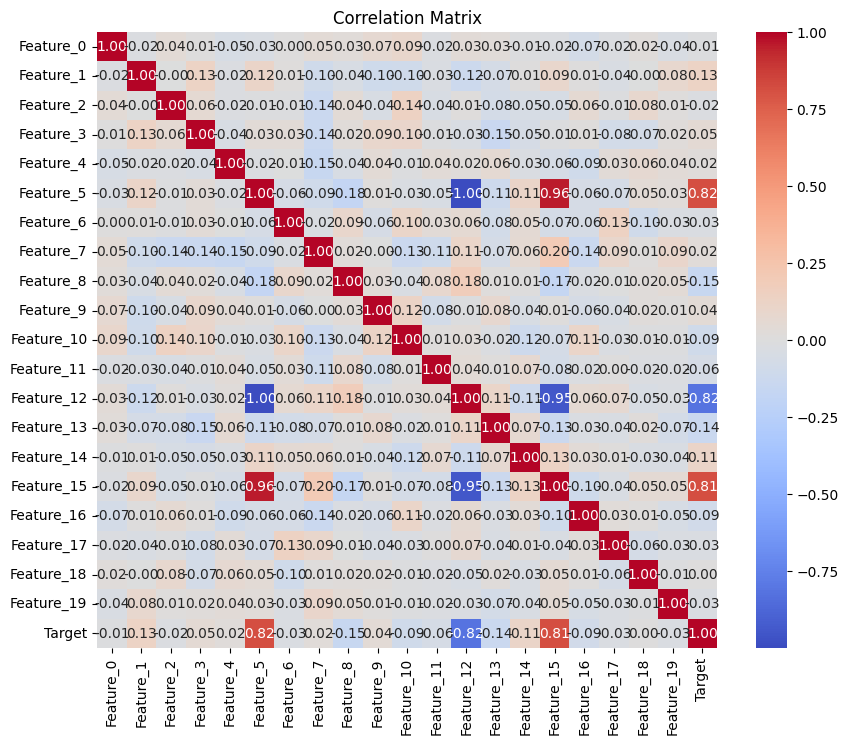

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import accuracy_score, roc_auc_score


# Step 1: Generate synthetic classification dataset
X, y = make_classification(n_samples=300, n_features=20, n_classes=2, random_state=42)

# Convert to DataFrame for easier analysis
df = pd.DataFrame(X, columns=[f"Feature_{i}" for i in range(X.shape[1])])
df['Target'] = y

# 1. Dataset Overview
print("Dataset Overview:")
print(df.info())
print("Class Distribution:")
print(df['Target'].value_counts())

# 2. Feature Analysis
plt.figure(figsize=(15, 6))
for i, col in enumerate(df.columns[:-1]):
    plt.subplot(3, 7, i + 1)
    sns.histplot(df, x=col, hue='Target', kde=True, palette='pastel', element='step', legend=False)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

# 3. Correlation Analysis
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()




In [ ]:
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class DecisionTree:
    def __init__(self, max_depth=5, max_features='sqrt'):
        self.max_depth = max_depth
        self.max_features = max_features

    def fit(self, X, y):
        self.n_classes_ = len(set(y))
        self.n_features_ = X.shape[1]
        if self.max_features == 'sqrt':
            self.max_features = int(np.sqrt(self.n_features_))
        self.tree_ = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(set(y))
        if (depth >= self.max_depth or n_labels == 1 or n_samples < 2):
            return Counter(y).most_common(1)[0][0]
        # Select random subset of features
        feature_indices = np.random.choice(n_features, size=self.max_features, replace=False)
        # Select best split from random subset
        best_gini = float('inf')
        best_idx, best_thr = None, None
        for idx in feature_indices:
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
            for i in range(1, n_samples):
                if classes[i - 1] != classes[i]:
                    thr = (thresholds[i - 1] + thresholds[i]) / 2
                    left = [y[j] for j in range(n_samples) if X[j, idx] < thr]
                    right = [y[j] for j in range(n_samples) if X[j, idx] >= thr]
                    gini = (len(left) * self._gini_impurity(left) + len(right) * self._gini_impurity(right)) / n_samples
                    if gini < best_gini:
                        best_gini = gini
                        best_idx = idx
                        best_thr = thr
        if best_gini == float('inf'):
            return Counter(y).most_common(1)[0][0]
        # Recur
        left_idx = np.where(X[:, best_idx] < best_thr)
        right_idx = np.where(X[:, best_idx] >= best_thr)
        left = self._grow_tree(X[left_idx], y[left_idx], depth + 1)
        right = self._grow_tree(X[right_idx], y[right_idx], depth + 1)
        return (best_idx, best_thr, left, right)

    def _gini_impurity(self, y):
        if len(y) == 0:
            return 0
        p = np.bincount(y) / len(y)
        return 1 - np.sum(p ** 2)

    def predict(self, X):
        return [self._predict(inputs) for inputs in X]

    def _predict(self, inputs):
        node = self.tree_
        while isinstance(node, tuple):
            idx, thr, left, right = node
            if inputs[idx] < thr:
                node = left
            else:
                node = right
        return node

class RandomForest:
    def __init__(self, n_trees=100, max_depth=5, max_features='sqrt'):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.max_features = max_features

    def fit(self, X, y):
        self.trees = []
        self.indices = []
        n_samples = X.shape[0]
        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth=self.max_depth, max_features=self.max_features)
            indices = np.random.choice(n_samples, size=n_samples, replace=True)
            tree.fit(X[indices], y[indices])
            self.trees.append(tree)
            self.indices.append(indices)

    def predict(self, X):
        predictions = np.zeros((X.shape[0], self.n_trees))
        for i, tree in enumerate(self.trees):
            predictions[:, i] = tree.predict(X)
        return np.array([np.bincount(row.astype(int)).argmax() for row in predictions])

def calculate_oob_error(X, y, forest):
    n_samples = X.shape[0]
    n_classes = len(np.unique(y))
    n_trees = forest.n_trees
    predictions = np.zeros((n_samples, n_trees))
    votes = np.zeros((n_samples, n_classes))

    for i, tree in enumerate(forest.trees):
        indices = forest.indices[i]
        oob_indices = np.array([idx for idx in range(n_samples) if idx not in indices])
        if len(oob_indices) > 0:
            predictions[oob_indices, i] = tree.predict(X[oob_indices])
            for j, idx in enumerate(oob_indices):
                votes[idx, int(predictions[idx, i])] += 1

    oob_predictions = np.argmax(votes, axis=1)
    oob_err = 1 - accuracy_score(y, oob_predictions)

    return oob_err

# Generate synthetic classification dataset
X, y = make_classification(n_samples=300, n_features=20, n_classes=2, random_state=42)

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train Random Forest with feature randomness
rf = RandomForest(n_trees=100, max_depth=5, max_features='sqrt')
rf.fit(X_train, y_train)

# Calculate out-of-bag error
oob_err = calculate_oob_error(X_train, y_train, rf)
print("Out-of-Bag Error:", oob_err)

# Predict on the test set
y_pred = rf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Classification Accuracy:", accuracy)




Out-of-Bag Error: 0.08333333333333337
Classification Accuracy: 0.9666666666666667


In [ ]:
import matplotlib.pyplot as plt

# Define a function to plot a decision tree
def plot_decision_tree(tree, feature_names, depth=0):
    if isinstance(tree, tuple):
        idx, thr, left, right = tree
        feature_name = feature_names[idx]
        # Plot decision node
        print('  ' * depth + f'if {feature_name} <= {thr}:')
        plot_decision_tree(left, feature_names, depth + 1)
        print('  ' * depth + f'else:')
        plot_decision_tree(right, feature_names, depth + 1)
    else:
        # Leaf node
        print('  ' * depth + f'class: {tree}')

# Select a few decision trees for visualization
trees_to_visualize = [0, 1, 2, 3, 4]  # You can adjust this list as needed

for i in trees_to_visualize:
    print(f"Decision Tree {i+1}:")
    plot_decision_tree(rf.trees[i].tree_, [f'Feature {i}' for i in range(20)])
    print()

Decision Tree 1:
if Feature 16 <= -0.10819155980095548:
  if Feature 5 <= -0.5556826117915739:
    if Feature 1 <= -1.7660957685056493:
      class: 1
    else:
      class: 0
  else:
    if Feature 5 <= 0.11025235711227599:
      if Feature 7 <= 0.2450351348700156:
        class: 0
      else:
        class: 1
    else:
      class: 1
else:
  if Feature 8 <= -0.8167103980055227:
    if Feature 11 <= 0.4935109399717813:
      class: 1
    else:
      if Feature 12 <= -0.07721413968974511:
        class: 1
      else:
        class: 0
  else:
    if Feature 12 <= 0.06511437595748008:
      if Feature 5 <= 0.6193631165657494:
        if Feature 16 <= 0.15883732685947966:
          class: 0
        else:
          class: 1
      else:
        if Feature 8 <= -0.7900716067080715:
          class: 0
        else:
          class: 1
    else:
      if Feature 2 <= -1.8646480585248293:
        if Feature 18 <= -0.509138310571517:
          class: 1
        else:
          class: 0
      else:

<h2> B. SCIKIT-LEARN IMPLEMENTATION OF RANDOM FOREST </h2>

Out-of-Bag Error: 0.07916666666666672
Classification Accuracy: 0.9666666666666667


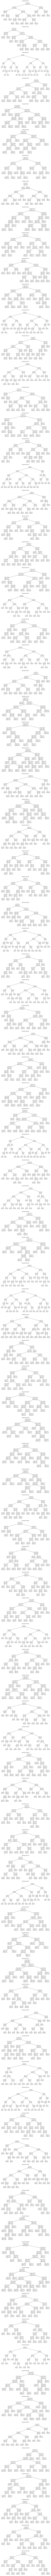

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score

# Generate synthetic classification dataset
X, y = make_classification(n_samples=300, n_features=20, n_classes=2, random_state=42)

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train Random Forest with feature randomness
rf = RandomForestClassifier(n_estimators=100, max_depth=5, max_features='sqrt', random_state=42, oob_score=True)
rf.fit(X_train, y_train)

# Calculate out-of-bag error
oob_error = 1 - rf.oob_score_
print("Out-of-Bag Error:", oob_error)

# Predict on the test set
y_pred = rf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Classification Accuracy:", accuracy)

# Plot decision trees properly one below the other
n_estimators = len(rf.estimators_)
fig, axes = plt.subplots(n_estimators, 1, figsize=(10, 5 * n_estimators))
for i, estimator in enumerate(rf.estimators_):
    plot_tree(estimator, ax=axes[i])
    axes[i].set_title('Decision Tree {}'.format(i+1))
plt.tight_layout()
plt.show()



<h2> C. CUSTOM IMPLEMENTATION OF ADABOOST </h2>

In [ ]:
# Imports
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

# Helper functions
def compute_error(y, y_pred, w_i):
    '''
    Calculate the error rate of a weak classifier m. Arguments:
    y: actual target value
    y_pred: predicted value by weak classifier
    w_i: individual weights for each observation


    Note that all arrays should be the same length
    '''

    return (sum(w_i * (np.not_equal(y, y_pred)).astype(int)))/sum(w_i)

def compute_alpha(error):
    '''
    Calculate the weight of a weak classifier m in the majority vote of the final classifier. Arguments:
    error: error rate from weak classifier m
    '''
    return 0.5*np.log((1 - error) / error)

def update_weights(w_i, alpha, y, y_pred):
    '''
    Update individual weights w_i after a boosting iteration. Arguments:
    w_i: individual weights for each observation
    y: actual target value
    y_pred: predicted value by weak classifier
    alpha: weight of weak classifier used to estimate y_pred
    '''

    return w_i * np.exp(alpha * 2*(np.not_equal(y, y_pred)).astype(int)-1) / np.sum( w_i * np.exp(alpha * 2*(np.not_equal(y, y_pred)).astype(int)-1))

# Define AdaBoost class
class AdaBoost:

    def __init__(self):
        # self.w_i = None
        self.alphas = []
        self.G_M = []
        self.M = None
        self.training_errors = []
        self.prediction_errors = []

    def fit(self, X, y, M = 100):
        '''
        Fit model. Arguments:
        X: independent variables
        y: target variable
        M: number of boosting rounds. Default is 100
        '''

        # Clear before calling
        self.alphas = []
        self.training_errors = []
        self.M = M

        # Iterate over M weak classifiers
        for m in range(0, M):

            # Set weights for current boosting iteration
            if m == 0:
                w_i = np.ones(len(y)) * 1 / len(y)  # At m = 0, weights are all the same and equal to 1 / N
            else:
                w_i = update_weights(w_i, alpha_m, y, y_pred)
            # print(w_i)

            # (a) Fit weak classifier and predict labels
            G_m = DecisionTreeClassifier(max_depth = 1)     # Stump: Two terminal-node classification tree
            G_m.fit(X, y, sample_weight = w_i)
            y_pred = G_m.predict(X)

            self.G_M.append(G_m) # Save to list of weak classifiers

            # (b) Compute error
            error_m = compute_error(y, y_pred, w_i)
            self.training_errors.append(error_m)
            # print(error_m)

            # (c) Compute alpha
            alpha_m = compute_alpha(error_m)
            self.alphas.append(alpha_m)
            # print(alpha_m)

        assert len(self.G_M) == len(self.alphas)


    def prediction(self, X):
        '''
        Predict using fitted model. Arguments:
        X: independent variables
        '''

        # Initialise dataframe with weak predictions for each observation
        weak_preds = pd.DataFrame(index = range(len(X)), columns = range(self.M))

        # Predict class label for each weak classifier, weighted by alpha_m
        for m in range(self.M):
            y_pred_m = self.G_M[m].predict(X) * self.alphas[m]
            weak_preds.iloc[:,m] = y_pred_m

        # Estimate final predictions
        y_pred = (1 * np.sign(weak_preds.T.sum())).astype(int)

        return y_pred

    def error_rates(self, X, y):
        '''
        Get the error rates of each weak classifier. Arguments:
        X: independent variables
        y: target variables associated to X
        '''

        self.prediction_errors = [] # Clear before calling

        # Predict class label for each weak classifier
        for m in range(self.M):
            y_pred_m = self.G_M[m].predict(X)
            error_m = compute_error(y = y, y_pred = y_pred_m, w_i = np.ones(len(y)))
            self.prediction_errors.append(error_m)

In [ ]:
# Generate classification dataset
X, y = make_classification(n_samples= 1000, n_features = 20, random_state = 42)
y = y * 2 - 1       # Original AdaBoost uses {1, -1} as class labels

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
# Fit model
ab = AdaBoost()
ab.fit(X_train, y_train, M = 400)

# Predict on test set
y_pred = ab.prediction(X_test)

<ipython-input-18-547bb251c623>:104: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  weak_preds.iloc[:,m] = y_pred_m
<ipython-input-18-547bb251c623>:104: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  weak_preds.iloc[:,m] = y_pred_m
<ipython-input-18-547bb251c623>:104: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  weak_p

In [ ]:

print('The ROC-AUC score of the model is:', round(roc_auc_score(y_test, y_pred), 4))

The ROC-AUC score of the model is: 0.8621


<h2> EXPLANATORY PLOTS FOR CUSTOM IMPLEMENTATION OF ADABOOST </h2>

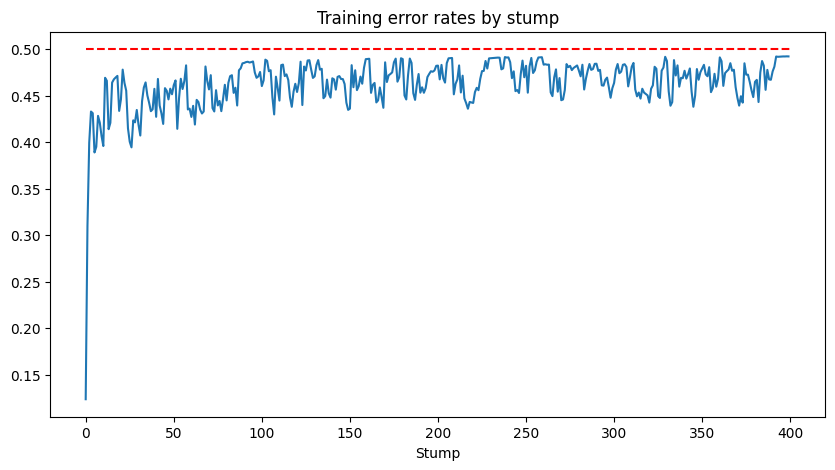

In [ ]:
# Error rates during training
plt.figure(figsize=(10,5))
plt.plot(ab.training_errors)
plt.hlines(0.5, 0, 400, colors = 'red', linestyles='dashed')
plt.title('Training error rates by stump')
plt.xlabel('Stump')
plt.show()

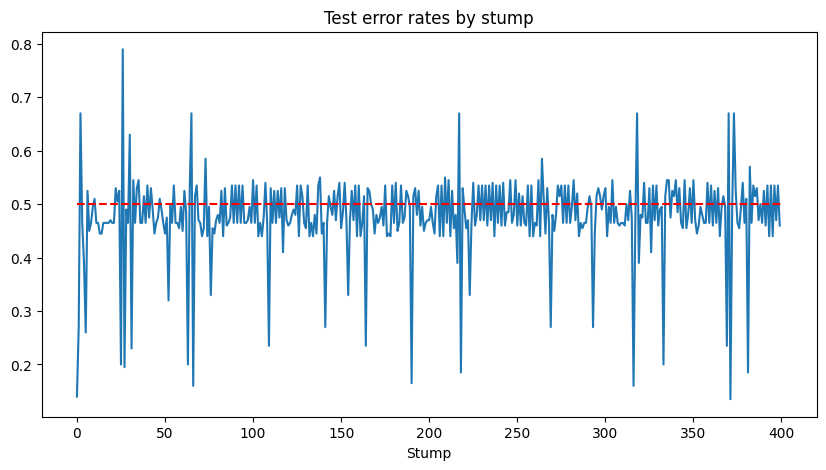

In [ ]:
# Error rates out of sample
ab.error_rates(X_test, y_test)
plt.figure(figsize=(10,5))
plt.plot(ab.prediction_errors)
plt.hlines(0.5, 0, 400, colors = 'red', linestyles='dashed')
plt.title('Test error rates by stump')
plt.xlabel('Stump')
plt.show()

In [ ]:
def compute_error(y, y_pred, w_i):
    '''
    Calculate the error rate of a weak classifier m. Arguments:
    y: actual target value
    y_pred: predicted value by weak classifier
    w_i: individual weights for each observation


    Note that all arrays should be the same length
    '''
    return (sum(w_i * (np.not_equal(y, y_pred)).astype(int)))/sum(w_i)

print('Error rate of metaclassifier:', round(compute_error(y_test, y_pred, np.ones(len(y_test))), 4))

Error rate of metaclassifier: 0.14


<h2> D. SCIKIT-LEARN IMPLEMENTATION OF ADABOOST </h2>

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
A = AdaBoostClassifier(n_estimators = 500)
A.fit(X_train, y_train)
y_pred_sk = A.predict(X_test)
print('The ROC-AUC:', round(roc_auc_score(y_test, y_pred), 5))

The ROC-AUC: 0.86212


<h3>References:</h3>
    <ol>
    <li> <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html" class="wikilink">https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html</a> </li>
    <li> <a href="https://github.com/AlvaroCorrales/AdaBoost/blob/main/Test%20AdaBoost.ipynb" class="wikilink">https://github.com/AlvaroCorrales/AdaBoost/blob/main/Test%20AdaBoost.ipynb</a> </li>
    <li> <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html" class="wikilink">https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html</a> </li>
   </ol>